In [4]:
pip install opencv-python scikit-learn numpy matplotlib tensorflow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

%matplotlib inline

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)


/Users/snithshibu/Documents/Mulearn/ig-ai/#cl-ai-imageclassification/venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


/var/folders/vd/fts_cgrx1mldp937nd4_j_0w0000gn/T/ipykernel_7104/3747900480.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y_train[i])])


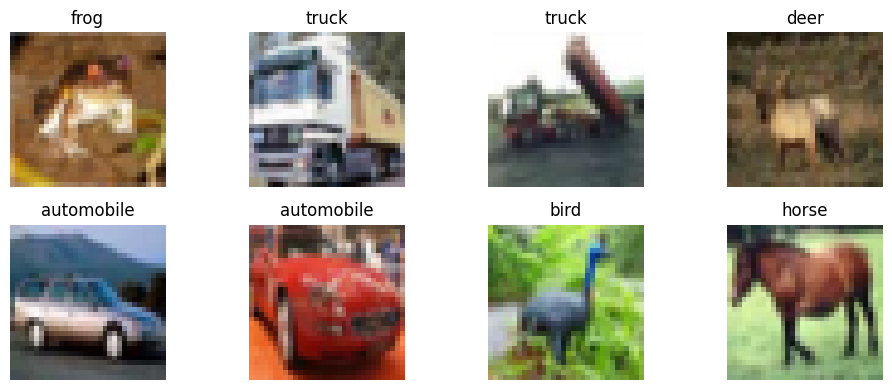

In [6]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

plt.figure(figsize=(10, 4))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[int(y_train[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:
N_SAMPLES = 10000  

X = X_train[:N_SAMPLES]
y = y_train[:N_SAMPLES].ravel()  

print("Subset images shape:", X.shape)
print("Subset labels shape:", y.shape)

def preprocess_image(img):
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    resized = cv2.resize(gray, (32, 32), interpolation=cv2.INTER_AREA)

    alpha = 1.3  
    beta = 30    
    enhanced = cv2.convertScaleAbs(resized, alpha=alpha, beta=beta)

    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    normalized = blurred.astype("float32") / 255.0

    return normalized

X_preprocessed = np.array([preprocess_image(img) for img in X])

print("Preprocessed images shape:", X_preprocessed.shape)


Subset images shape: (10000, 32, 32, 3)
Subset labels shape: (10000,)
Preprocessed images shape: (10000, 32, 32)


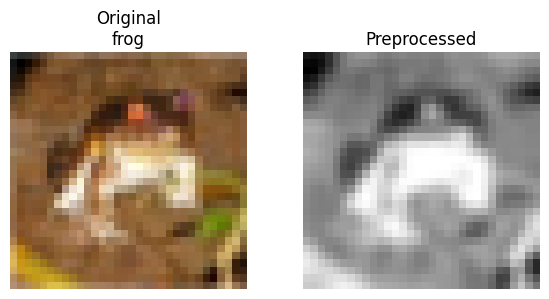

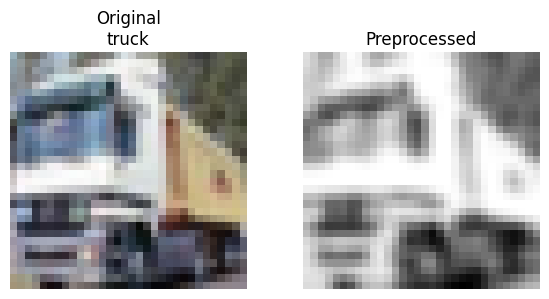

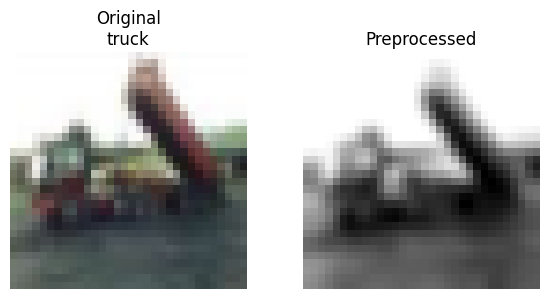

In [8]:
def show_original_and_preprocessed(index):
    original = X[index]              
    processed = X_preprocessed[index] 

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original\n" + class_names[int(y[index])])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap="gray")
    plt.title("Preprocessed")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

show_original_and_preprocessed(0)
show_original_and_preprocessed(1)
show_original_and_preprocessed(2)


In [9]:
N, H, W = X_preprocessed.shape
X_flat = X_preprocessed.reshape(N, H * W)

print("Flattened feature shape:", X_flat.shape)

X_train_flat, X_val_flat, y_train_sub, y_val_sub = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

print("Train features:", X_train_flat.shape)
print("Val features:", X_val_flat.shape)
print("Train labels:", y_train_sub.shape)
print("Val labels:", y_val_sub.shape)


Flattened feature shape: (10000, 1024)
Train features: (8000, 1024)
Val features: (2000, 1024)
Train labels: (8000,)
Val labels: (2000,)


In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

svm_clf = SVC(kernel="rbf", C=2.0, gamma="scale")  

print("Training SVM... this may take a few minutes.")
svm_clf.fit(X_train_flat, y_train_sub)

y_val_pred = svm_clf.predict(X_val_flat)
val_acc = accuracy_score(y_val_sub, y_val_pred)

print("Validation accuracy:", val_acc)


Training SVM... this may take a few minutes.
Validation accuracy: 0.3905


<Figure size 800x800 with 0 Axes>

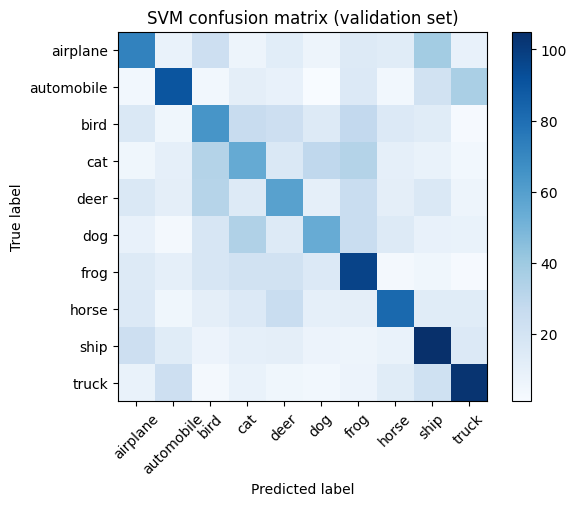

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_val_sub, y_val_pred)

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=False, cmap="Blues", xticks_rotation=45)
plt.title("SVM confusion matrix (validation set)")
plt.show()


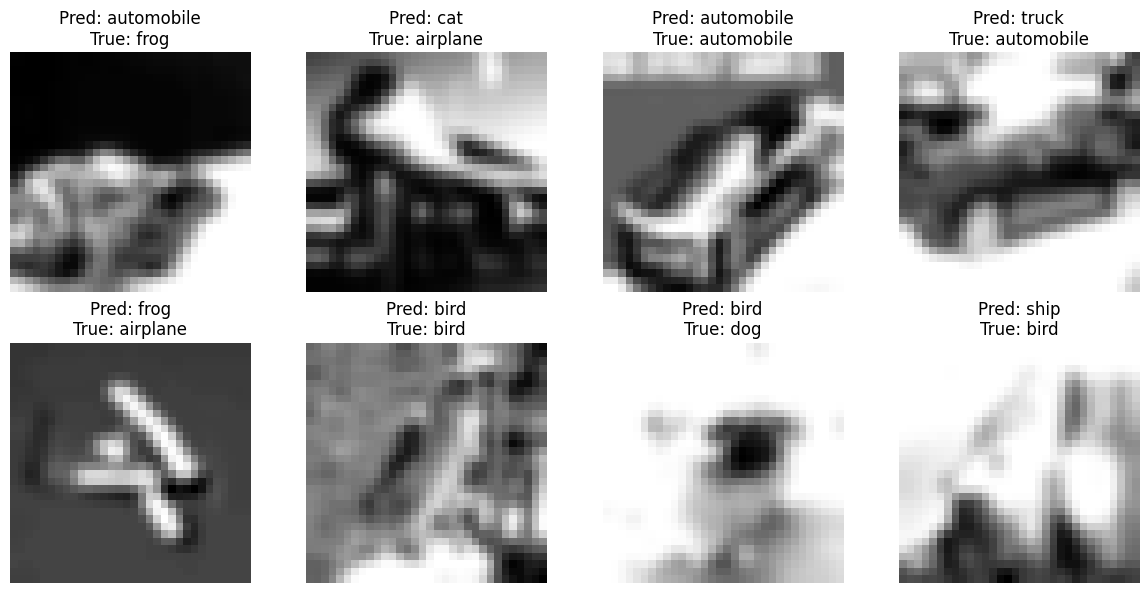

In [12]:
def show_val_predictions(n_samples=8):
    plt.figure(figsize=(12, 6))

    indices = np.random.choice(len(X_val_flat), size=n_samples, replace=False)

    for i, idx in enumerate(indices):
        img_flat = X_val_flat[idx]
        img_proc = img_flat.reshape(32, 32)  
        true_label = class_names[int(y_val_sub[idx])]
        pred_label = class_names[int(y_val_pred[idx])]

        plt.subplot(2, 4, i + 1)
        plt.imshow(img_proc, cmap="gray")
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_val_predictions(8)


In [13]:
from tensorflow.keras.utils import to_categorical

X_train_cnn = X_train.astype("float32") / 255.0
X_test_cnn = X_test.astype("float32") / 255.0

num_classes = 10

y_train_cnn = to_categorical(y_train, num_classes)
y_test_cnn = to_categorical(y_test, num_classes)

print("Train CNN data:", X_train_cnn.shape, y_train_cnn.shape)
print("Test  CNN data:", X_test_cnn.shape, y_test_cnn.shape)


Train CNN data: (50000, 32, 32, 3) (50000, 10)
Test  CNN data: (10000, 32, 32, 3) (10000, 10)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation="relu", padding="same"),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


/Users/snithshibu/Documents/Mulearn/ig-ai/#cl-ai-imageclassification/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,116,970 (4.26 MB)

 Trainable params: 1,116,970 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
batch_size = 64
epochs = 25  

history = model.fit(
    X_train_cnn, y_train_cnn,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    shuffle=True,
)


Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.8205 - loss: 0.5038 - val_accuracy: 0.7748 - val_loss: 0.6916
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.8226 - loss: 0.4975 - val_accuracy: 0.7830 - val_loss: 0.6557
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.8283 - loss: 0.4852 - val_accuracy: 0.7840 - val_loss: 0.6578
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.8335 - loss: 0.4694 - val_accuracy: 0.7764 - val_loss: 0.6693
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 95ms/step - accuracy: 0.8374 - loss: 0.4560 - val_accuracy: 0.7794 - val_loss: 0.6552
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.8427 - loss: 0.4331 - val_accuracy: 0.7854 - val_loss: 0.6631
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.8483 - loss: 0.4279 - val_accuracy: 0.7796 - val_loss: 0.7135
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.8479 - loss: 0.4291 

In [19]:
test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print("CNN test accuracy:", test_acc)

CNN test accuracy: 0.7849000096321106


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


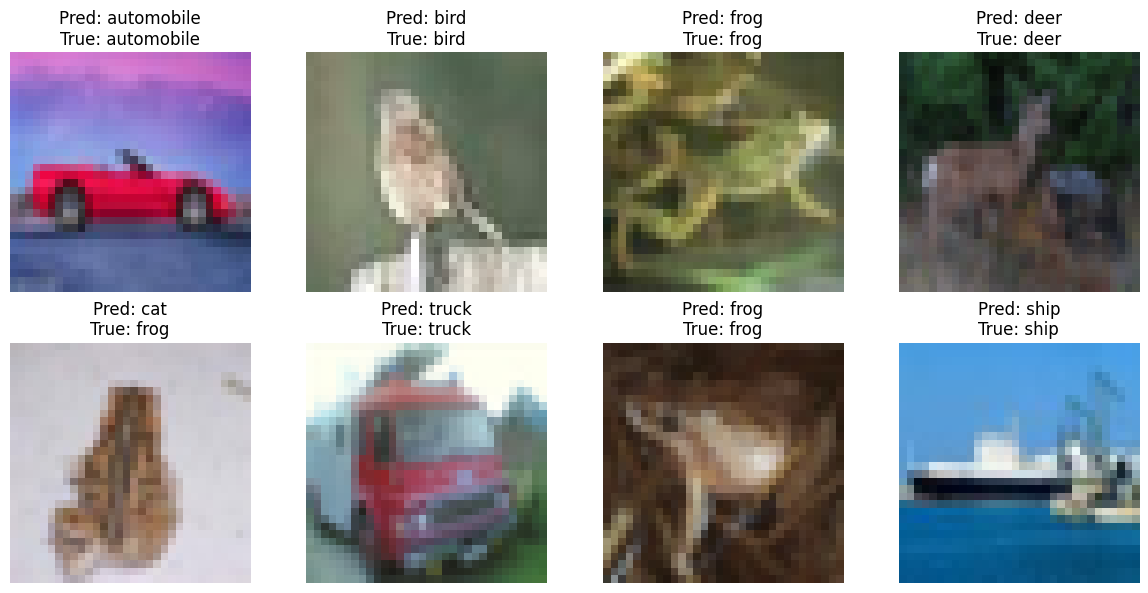

In [20]:
y_test_pred_probs = model.predict(X_test_cnn)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_true = np.argmax(y_test_cnn, axis=1)

def show_cnn_test_predictions(n_samples=8):
    plt.figure(figsize=(12, 6))
    indices = np.random.choice(len(X_test_cnn), size=n_samples, replace=False)

    for i, idx in enumerate(indices):
        img = X_test_cnn[idx]
        true_label = class_names[int(y_test_true[idx])]
        pred_label = class_names[int(y_test_pred[idx])]

        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_cnn_test_predictions(8)
